In [43]:
import ciw
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm.notebook import tqdm
import pandas as pd
import pylab
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.style.use('seaborn-whitegrid')

In [2]:
class SD():
    """
    A class to hold the SD component.
    """
    def __init__(
        self,
        initial_number_of_errors,
        new_book_rate,
        prob_error,
        report_rate,
        search_rate,
        **kwargs
    ):
        """
        Initialised the parameters for the SD component
        """
        p = prob_error
        self.ps = [(1 - p) * (p ** i) / (1 - (p ** (4))) for i in range(4)]
        self.B = [[initial_number_of_errors * pi] for pi in self.ps]
        self.new_book_rate = new_book_rate
        self.report_rate = report_rate
        self.search_rate = search_rate
        self.time = np.array([0])
    
    def differential_equations(self, y, time_domain, free_staff):
        """
        Defines the differential equations that define the system.
        Returns the value of the derivatives for each B_i.
        """
        B0, B1, B2, B3 = y
        total_errors = max(B1 + (2 * B2) + (3 * B3), 1)
        dB0dt = (self.ps[0] * self.new_book_rate) + (self.search_rate * free_staff * ((B1) / total_errors))
        dB1dt = (self.ps[1] * self.new_book_rate) + (self.search_rate * free_staff * ((B2 - B1) / total_errors))
        dB2dt = (self.ps[2] * self.new_book_rate) + (self.search_rate * free_staff * ((B3 - B2) / total_errors))
        dB3dt = (self.ps[3] * self.new_book_rate) + (self.search_rate * free_staff * ((-B3) / total_errors))
        return dB0dt, dB1dt, dB2dt, dB3dt

    def solve(self, t, **kwargs):
        """
        Solves the differential equations from
        the time of the pervious event to time t.
        """
        leaving_class = kwargs['leaving_class']
        free_staff = kwargs['free_staff']
        
        y = (self.B[0][-1], self.B[1][-1], self.B[2][-1], self.B[3][-1])
        relevant = (self.time_domain <= t) & (self.time_domain >= self.time[-1])
        times_between_events = np.concatenate((np.array([self.time[-1]]), self.time_domain[relevant], np.array([t])), axis=None)
        results = odeint(self.differential_equations, y, times_between_events, args = (free_staff,))
        B0, B1, B2, B3 = results.T
        self.B[0] = np.append(self.B[0], B0)
        self.B[1] = np.append(self.B[1], B1)
        self.B[2] = np.append(self.B[2], B2)
        self.B[3] = np.append(self.B[3], B3)
        
        f = [1 if i == leaving_class else 0 for i in range(3)]
        self.B[0][-1] = self.B[0][-1] + f[0]
        self.B[1][-1] = max(self.B[1][-1] + f[1] - f[0], 0)
        self.B[2][-1] = max(self.B[2][-1] + f[2] - f[1], 0)
        self.B[3][-1] = max(self.B[3][-1] - f[2], 0)

        self.time = np.append(self.time, times_between_events)

In [3]:
class HybridNode(ciw.Node):
    """
    A Node object that communicates with the SD component at
    the relevant points of the simulation.
    """
    def update_free_staff(self):
        """
        Updates the `free_staff` attribute with the number
        of staff that are currently free.
        """
        self.free_staff = sum(not s.busy for s in self.servers)

    def release(self, next_individual_index, next_node):
        """
        Releases the current individual at the end of their service.
        Solves the SD component.
        """
        leaving_class = self.all_individuals[next_individual_index].customer_class
        super().release(next_individual_index, next_node)
        self.simulation.SD.solve(t=self.get_now(), leaving_class=leaving_class, free_staff=self.free_staff)
        self.update_free_staff()

In [4]:
class HybridSimulation(ciw.Simulation):
    """
    A Simulation object that includes the SD component as an
    attribute and communicates with it at the relevant points
    of the simulation.
    """
    def __init__(self, network, **kwargs):
        """
        Initialises the HybridSimulation object.
        Creates and attaches the SD component.
        """
        self.SD = SD(**kwargs)
        super().__init__(network=network, node_class=HybridNode)
        
    def simulate_until_max_time(self, max_simulation_time, n_steps):
        """
        Runs the simulation until the max_simulation time.
        Creates the time domain, runs the simulation, and solves
        the SD component one last time.
        """
        self.nodes[1].free_staff = self.nodes[1].c
        self.SD.time_domain = np.linspace(0, max_simulation_time, n_steps)
        super().simulate_until_max_time(max_simulation_time)
        self.SD.solve(t=max_simulation_time, leaving_class=None, free_staff=self.nodes[1].free_staff)

In [5]:
def get_arrival_distribution(i):
    """
    Creates a distribution class and returns and instance of that class.
    Creates a distribution class for arrivals from B_i.
    Solves the SD component before sampling.
    """
    class SolveSDArrivals(ciw.dists.Distribution):            
        def sample(self, t=None, ind=None):
            if t > 0:
                self.simulation.SD.solve(t, leaving_class=None, free_staff=self.simulation.nodes[1].free_staff)
            rate = self.simulation.SD.B[i][-1] * i * self.simulation.SD.report_rate
            return ciw.dists.Exponential(rate).sample()
    return SolveSDArrivals()

In [6]:
def run_trial(prob_error, number_of_servers, initial_number_of_errors, n_weeks):
    N = ciw.create_network(
        arrival_distributions={
            'Class 0': [get_arrival_distribution(1)],
            'Class 1': [get_arrival_distribution(2)],
            'Class 2': [get_arrival_distribution(3)]},
        service_distributions={
            'Class 0': [ciw.dists.Uniform(1/24, 2/24)],
            'Class 1': [ciw.dists.Uniform(1/24, 2/24)],
            'Class 2': [ciw.dists.Uniform(1/24, 2/24)]},
        number_of_servers=[number_of_servers]
    )
    
    Q = HybridSimulation(
        network=N,
        initial_number_of_errors=initial_number_of_errors,
        new_book_rate=100,
        prob_error=prob_error,
        report_rate=1,
        search_rate=0.4
    )
    
    Q.simulate_until_max_time(n_weeks * 7, n_weeks * 7 * 100)
    results = {}
    results['t'] = Q.SD.time
    results['Total Errors'] = Q.SD.B[1] + (2 * Q.SD.B[2]) + (3 * Q.SD.B[3])    
    return results

In [7]:
def run_experiment(prob_error, number_of_servers, initial_number_of_errors, n_weeks, num_trials, means_only=False):
    results = []
    for trial in tqdm(range(num_trials), position=2, leave=False, desc="Trials Loop"):
        ciw.seed(trial)
        r = run_trial(prob_error, number_of_servers, initial_number_of_errors, n_weeks)
        results.append(r)
    dfs = [pd.DataFrame({trial: results[trial]['Total Errors']}, index=results[trial]['t']).drop_duplicates() for trial in range(num_trials)]
    all_data = pd.concat([df.loc[~df.index.duplicated(keep='first')] for df in dfs], join='outer', axis=1)
    if means_only:
        return all_data.dropna().T.mean()
    return all_data

In [8]:
def run_all_experiments(probs, servers, initial_number_of_errors, n_weeks, num_trials):
    data = {}
    for p in tqdm(probs, position=0, desc="Probability Loop"):
        data[str(p)] = {}
        for c in tqdm(servers, position=1, leave=False, desc="Servers Loop"):
            data[str(p)][c] = run_experiment(prob_error=p, number_of_servers=c, initial_number_of_errors=initial_number_of_errors, n_weeks=n_weeks, num_trials=num_trials, means_only=True)
    return data

In [61]:
def plot_experiments(data, probs, servers, n_weeks, rolling_frame, num_trials):
    cmap_list = pylab.cm.get_cmap('viridis', len(servers))
    fig, ax = plt.subplots(2, 2, figsize=(10, 8))
    coords = [(0, 0), (0, 1), (1, 0), (1, 1)]
    for i, p in enumerate(probs):
        for j, c in enumerate(servers):
            ax[coords[i]].plot(data[str(p)][c].rolling(rolling_frame, center=True).mean(), c=cmap_list(j))
        ax[coords[i]].set_title(f"Error Probability = {p}", fontsize=14)
        ax[coords[i]].set_ylim(bottom=0)
        ax[coords[i]].set_xlabel("Weeks", fontsize=16)
        ax[coords[i]].set_ylabel("Number of Errors Published", fontsize=14)
        ax[coords[i]].set_xticks(range(0, (n_weeks+1)*7, 7))
        ax[coords[i]].set_xticklabels(range(n_weeks + 1))
    fig.subplots_adjust(right=0.8, hspace=0.3, wspace=0.2)
    cax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    norm = mpl.colors.Normalize(vmin=servers[0],vmax=servers[-1])
    sm = plt.cm.ScalarMappable(cmap=cmap_list, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ticks=servers, boundaries=np.arange(servers[0]-0.5,servers[-1]+1.5,1), cax=cax)
    cbar.set_label("Number of Staff", fontsize=14)
    return fig

In [62]:
def plot_experiments_cy(data, probs, servers, n_weeks, rolling_frame, num_trials):
    cmap_list = pylab.cm.get_cmap('viridis', len(servers))
    fig, ax = plt.subplots(2, 2, figsize=(10, 8))
    coords = [(0, 0), (0, 1), (1, 0), (1, 1)]
    for i, p in enumerate(probs):
        for j, c in enumerate(servers):
            ax[coords[i]].plot(data[str(p)][c].rolling(rolling_frame, center=True).mean(), c=cmap_list(j))
        ax[coords[i]].set_title(f"Tebygolrwydd o Wall = {p}", fontsize=14)
        ax[coords[i]].set_ylim(bottom=0)
        ax[coords[i]].set_xlabel("Wythnosau", fontsize=16)
        ax[coords[i]].set_ylabel("Nifer of Wallau y Cyhoeddwyd", fontsize=14)
        ax[coords[i]].set_xticks(range(0, (n_weeks+1)*7, 7))
        ax[coords[i]].set_xticklabels(range(n_weeks + 1))
    fig.subplots_adjust(right=0.8, hspace=0.3, wspace=0.2)
    cax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    norm = mpl.colors.Normalize(vmin=servers[0],vmax=servers[-1])
    sm = plt.cm.ScalarMappable(cmap=cmap_list, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ticks=servers, boundaries=np.arange(servers[0]-0.5,servers[-1]+1.5,1), cax=cax)
    cbar.set_label("Nifer o Aelodau Staff", fontsize=14)
    return fig

In [10]:
data = run_all_experiments(
    probs=[0.05, 0.1, 0.15, 0.2],
    servers=range(6, 15),
    initial_number_of_errors=100,
    n_weeks=26,
    num_trials=20
)

Probability Loop:   0%|          | 0/4 [00:00<?, ?it/s]

Servers Loop:   0%|          | 0/9 [00:00<?, ?it/s]

Trials Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Trials Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Trials Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Trials Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Trials Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Trials Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Trials Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Trials Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Trials Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Servers Loop:   0%|          | 0/9 [00:00<?, ?it/s]

Trials Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Trials Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Trials Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Trials Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Trials Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Trials Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Trials Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Trials Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Trials Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Servers Loop:   0%|          | 0/9 [00:00<?, ?it/s]

Trials Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Trials Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Trials Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Trials Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Trials Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Trials Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Trials Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Trials Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Trials Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Servers Loop:   0%|          | 0/9 [00:00<?, ?it/s]

Trials Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Trials Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Trials Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Trials Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Trials Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Trials Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Trials Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Trials Loop:   0%|          | 0/20 [00:00<?, ?it/s]

Trials Loop:   0%|          | 0/20 [00:00<?, ?it/s]

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


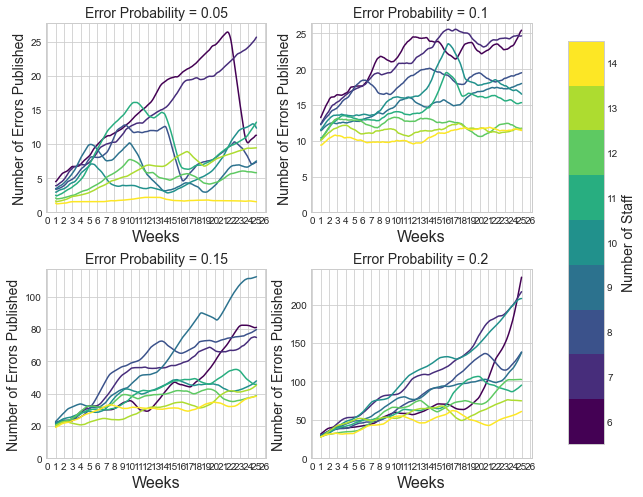

In [63]:
fig = plot_experiments(
    data = data,
    probs=[0.05, 0.1, 0.15, 0.2],
    servers=range(6, 15),
    n_weeks=26,
    rolling_frame=100*14,
    num_trials=18
);
fig.savefig("hybrid_total_errors_over_time_by_server_by_prob.jpeg")

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


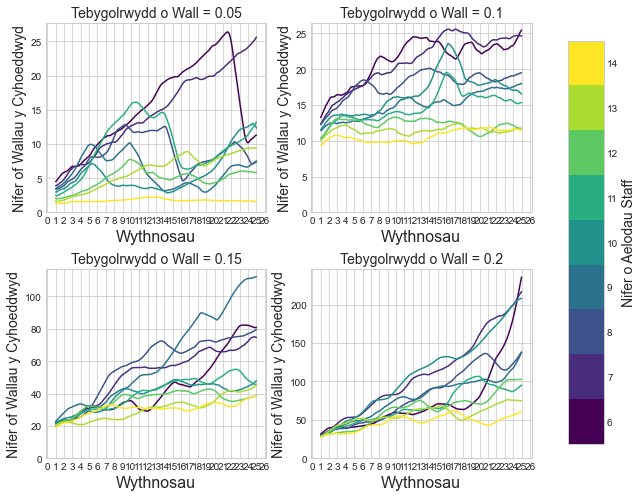

In [64]:
fig = plot_experiments_cy(
    data = data,
    probs=[0.05, 0.1, 0.15, 0.2],
    servers=range(6, 15),
    n_weeks=26,
    rolling_frame=100*14,
    num_trials=18
);
fig.savefig("hybrid_total_errors_over_time_by_server_by_prob_cy.jpeg")

In [67]:
servers = range(4, 61, 2)
resulting_errors = []
for c in tqdm(servers):
    e = run_experiment(prob_error=0.25, initial_number_of_errors=100, number_of_servers=c, n_weeks=8, num_trials=50)
    resulting_errors.append(e.iloc[-1])

  0%|          | 0/29 [00:00<?, ?it/s]

Trials Loop:   0%|          | 0/50 [00:00<?, ?it/s]

Trials Loop:   0%|          | 0/50 [00:00<?, ?it/s]

Trials Loop:   0%|          | 0/50 [00:00<?, ?it/s]

Trials Loop:   0%|          | 0/50 [00:00<?, ?it/s]

Trials Loop:   0%|          | 0/50 [00:00<?, ?it/s]

Trials Loop:   0%|          | 0/50 [00:00<?, ?it/s]

Trials Loop:   0%|          | 0/50 [00:00<?, ?it/s]

Trials Loop:   0%|          | 0/50 [00:00<?, ?it/s]

Trials Loop:   0%|          | 0/50 [00:00<?, ?it/s]

Trials Loop:   0%|          | 0/50 [00:00<?, ?it/s]

Trials Loop:   0%|          | 0/50 [00:00<?, ?it/s]

Trials Loop:   0%|          | 0/50 [00:00<?, ?it/s]

Trials Loop:   0%|          | 0/50 [00:00<?, ?it/s]

Trials Loop:   0%|          | 0/50 [00:00<?, ?it/s]

Trials Loop:   0%|          | 0/50 [00:00<?, ?it/s]

Trials Loop:   0%|          | 0/50 [00:00<?, ?it/s]

Trials Loop:   0%|          | 0/50 [00:00<?, ?it/s]

Trials Loop:   0%|          | 0/50 [00:00<?, ?it/s]

Trials Loop:   0%|          | 0/50 [00:00<?, ?it/s]

Trials Loop:   0%|          | 0/50 [00:00<?, ?it/s]

Trials Loop:   0%|          | 0/50 [00:00<?, ?it/s]

Trials Loop:   0%|          | 0/50 [00:00<?, ?it/s]

Trials Loop:   0%|          | 0/50 [00:00<?, ?it/s]

Trials Loop:   0%|          | 0/50 [00:00<?, ?it/s]

Trials Loop:   0%|          | 0/50 [00:00<?, ?it/s]

Trials Loop:   0%|          | 0/50 [00:00<?, ?it/s]

Trials Loop:   0%|          | 0/50 [00:00<?, ?it/s]

Trials Loop:   0%|          | 0/50 [00:00<?, ?it/s]

Trials Loop:   0%|          | 0/50 [00:00<?, ?it/s]

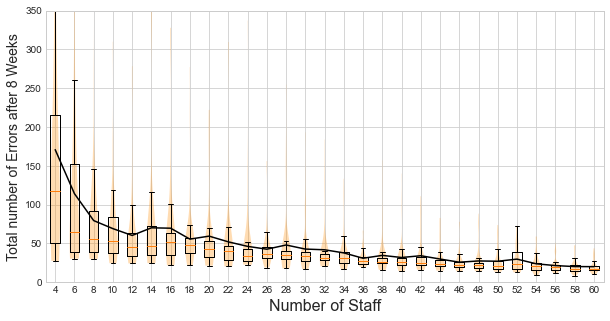

In [72]:
fig, ax = plt.subplots(1, figsize=(10, 5))
width = (servers[1] - servers[0]) / 2
ax.boxplot([a.dropna() for a in resulting_errors], positions=servers, showfliers=False, widths=width)
viols = ax.violinplot([a.dropna() for a in resulting_errors], positions=servers, showextrema=False, widths=width)
for pc in viols['bodies']:
    pc.set_facecolor('darkorange')
ax.plot(servers, [e.mean() for e in resulting_errors], c='black')
ax.set_xlabel("Number of Staff", fontsize=16)
ax.set_ylabel("Total number of Errors after 8 Weeks", fontsize=14)
ax.set_ylim(0, 350)
ax.set_xlim(servers[0] - width, servers[-1] + width)
fig.savefig("hybrid_total_errors_by_server.jpeg")

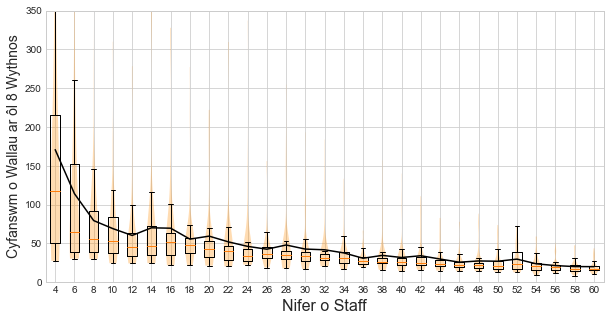

In [73]:
fig, ax = plt.subplots(1, figsize=(10, 5))
width = (servers[1] - servers[0]) / 2
ax.boxplot([a.dropna() for a in resulting_errors], positions=servers, showfliers=False, widths=width)
viols = ax.violinplot([a.dropna() for a in resulting_errors], positions=servers, showextrema=False, widths=width)
for pc in viols['bodies']:
    pc.set_facecolor('darkorange')
ax.plot(servers, [e.mean() for e in resulting_errors], c='black')
ax.set_xlabel("Nifer o Staff", fontsize=16)
ax.set_ylabel("Cyfanswm o Wallau ar ôl 8 Wythnos", fontsize=14)
ax.set_ylim(0, 350)
ax.set_xlim(servers[0] - width, servers[-1] + width)
fig.savefig("hybrid_total_errors_by_server_cy.jpeg")